*(you may prefer to view this notebook using Juypter's official notebook viewer - where equations are fully rendered correctly using LaTex - find that here: https://nbviewer.jupyter.org/github/noahbouchier/GSoC-PySAL-21/blob/master/Explanatory%20and%20Interactive%20Workbooks/kl_divergence.ipynb)*
# Calculating the Kullback–Leibler (KL) divergence profile

This workbook is a contribution towards the project to include a distortion index segregation statistic within the PySAL library, as part of Google Summer of Code. The distortion index segregation statistic draws its main inspiration from Olteanu et al (2019) paper, "[Segregation through the multiscalar lens](https://www.pnas.org/content/116/25/12250)".

Read on to see an example run-through of code used to calculate a [Kullback–Leibler (KL) divergence profile](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) - with the code ran with example data from the 2011 UK census from Leicester, a city in the East Midlands of England.

The data used can be found on my [Example Data - Leicester, UK](https://github.com/noahbouchier/GSoC-PySAL-21/tree/master/Example%20Data%20-%20Leicester%2C%20UK) repository.

The workbook is separated into a sequence of steps:

- Step 1 deals with reading in the data from Leicester.

A considerable amount of steps 2 and 3 use code from the work of [Cécile de Bézenac](https://www.turing.ac.uk/people/doctoral-students/cecile-de-bezenac), and which can be found within the Python files of this [segregation_index GitHub repository](https://github.com/ceciledebezenac/segregation_index/tree/master/divergence).

- Step 2 creates a population matrix - which is an easier format for the data being analysed to be stored in. This makes subsequent analysis more efficient (quicker to run).

- Step 3 begins the calculation of the KL divergence profile by creating the objects used in it's calculation. Using the formula taken from the Olteanu et al (2019) paper (see below), these objects are labelled *q* and *r*.

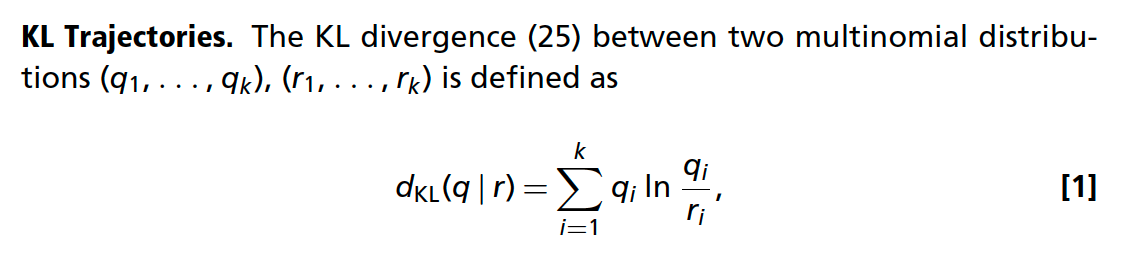

- Step 4 utilises the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function to calculate the KL divergence profile (which is also referred to as relative entropy), having used the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) to order geographical units with repect to their distance from one another.

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial
from scipy.spatial import distance_matrix

np.set_printoptions(suppress=True)

## Step 1 - Read in the data

First things first is to read the data into the working environment.

The data is a GeoPackage, called **leicester_ethnicity** (available from my [Example Data - Leicester, UK](https://github.com/noahbouchier/GSoC-PySAL-21/tree/master/Example%20Data%20-%20Leicester%2C%20UK) repository) - this is:
* An object containing demographic information and geometry (boundary data) of Leicester, UK
* Demographic information on ethnic identification of residents - at Output Area (OA) level
* Comprised of data from the 2011 UK census - follow links to: [explanation](https://www.ons.gov.uk/peoplepopulationandcommunity/culturalidentity/ethnicity/articles/ethnicityandnationalidentityinenglandandwales/2012-12-11), [boundary data](https://borders.ukdataservice.ac.uk/bds.html)  and [demographic data](https://www.nomisweb.co.uk/census/2011/ks201ew)

*Please note that both data sources, it is required to manually filter the required subset of data. The **leicester_ethnicity.gpkg** has been created by cleaning and merging the data downloaded from the respective sources.*

***For a comprehensive overview of how to create this form of data from UK census data, and then save it as a GeoPackage (.gpkg) see my [read_shapefile](https://github.com/noahbouchier/GSoC-PySAL-21/blob/master/Explanatory%20and%20Interactive%20Workbooks/read_shapefile.ipynb) interactive workbook. Within this workbook, I explain the process used to create the leicester_ethnicity.gpkg object.***

We must first set the file path for this GeoPackage - which you can follow within the GitHub repository.

In [2]:
fp_leics_eth = "../Example Data - Leicester, UK/leicester_ethnicity.gpkg"

We can then read in the files using the `gpd.read_file()` command

In [3]:
leicester_ethnicity = gpd.read_file(fp_leics_eth)

You can then get a look at the data using `.head`

In [4]:
leicester_ethnicity.head()

,oa11cd,all,w,w_b,w_i,w_g,w_o,m,m_wbc,m_wba,...,o,o_a,o_o,OBJECTID,LAD11CD,LAD16CD,LAD16NM,Shape__Are,Shape__Len,geometry
0,E00068657,413,359,345,4,0,10,11,9,0,...,0,0,0,66570,E06000016,E06000016,Leicester,58692.222687,2038.589497,"POLYGON ((458598.274 307772.432, 458585.335 30..."
1,E00068658,359,248,222,4,0,22,25,17,3,...,1,0,1,66571,E06000016,E06000016,Leicester,51615.237915,1577.523005,"POLYGON ((458785.675 307076.320, 458783.317 30..."
2,E00068659,334,273,241,2,2,28,12,1,6,...,15,3,12,66572,E06000016,E06000016,Leicester,98010.396652,1752.264912,"POLYGON ((458537.000 307386.000, 458544.063 30..."
3,E00068660,280,127,109,3,0,15,6,6,0,...,7,1,6,66573,E06000016,E06000016,Leicester,86993.668503,1671.905736,"POLYGON ((458253.000 307023.000, 458253.745 30..."
4,E00068661,320,225,194,6,0,25,27,20,0,...,8,0,8,66574,E06000016,E06000016,Leicester,281105.237427,2431.710951,"POLYGON ((459252.996 306971.333, 459257.693 30..."


Printing the columns is possible using `.columns`

In [5]:
print(leicester_ethnicity.columns)

Index(['oa11cd', 'all', 'w', 'w_b', 'w_i', 'w_g', 'w_o', 'm', 'm_wbc', 'm_wba',
       'm_w_a', 'm_o', 'a', 'a_i', 'a_p', 'a_b', 'a_c', 'a_o', 'b', 'b_a',
       'b_c', 'b_o', 'o', 'o_a', 'o_o', 'OBJECTID', 'LAD11CD', 'LAD16CD',
       'LAD16NM', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


The most pertinent columns for this analysis are:
- **oa11cd** - this is the identifying code (cd) for each output area (oa), with respect to the 2011 census (11)
- **geometry** - this is the spatial information to help plot each output area
- **respective ethnicity figures** - e.g *w* (white), *m* (mixed) - classifications taken from the UK census. See full codebook and heirarchy references below:

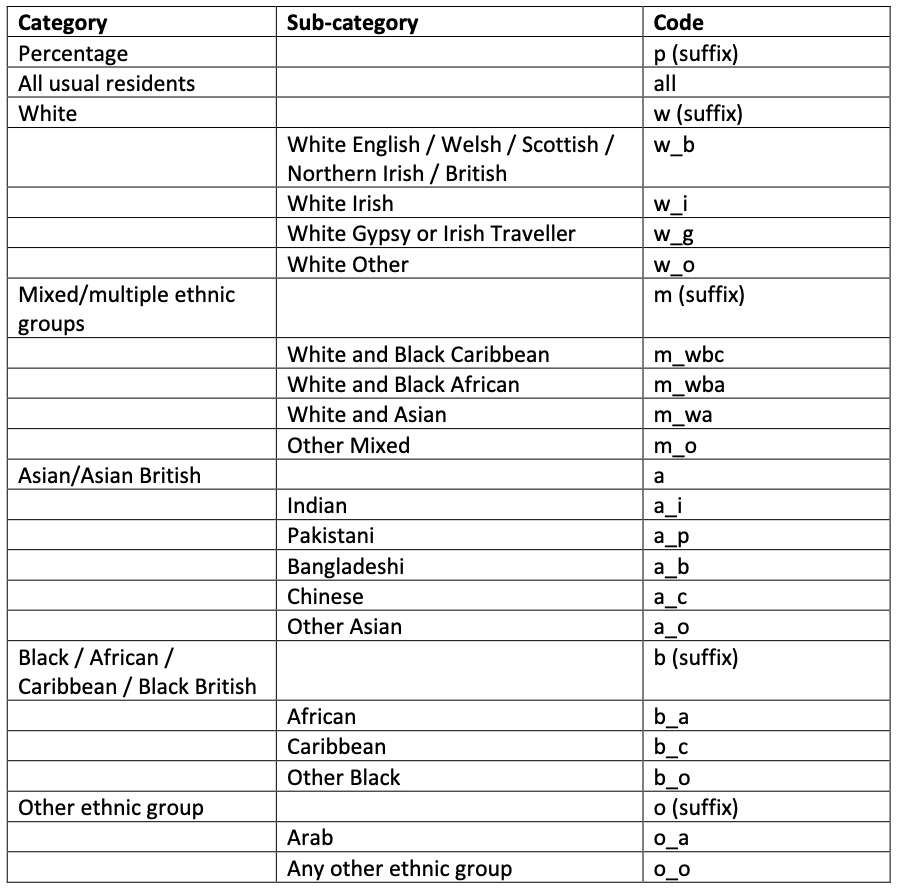

## Step 2 - Create population matrix

The `kl_divergence_profile` function pulls in a 'population matrix'.

This stems from the *basic_analysis.py* document - specifically the **`transform_population`** function from the **demographics** class.

This function is the first function from within the `Demographics` class - the command is from [this section of code](https://github.com/ceciledebezenac/segregation_index/blob/0e57b925450dad60e7cd9f987ba5ce499edccd8f/divergence/basic_analysis.py#L41-L46) - with the changes as follows:
- I have changed *'pop_matrix'* to *'leic_eth_population_matrix'* - to identify what it is I am working with here
- *'geodata'* is the *'leicester_ethnicity'* object we just read in
- *'groups'* is a list of the groups that you wish to include in your analysis

For ease, I will set this to the highest set of ethnicity classifications - as can be seen in the codebook included in Step 1 (see the first column).

These are: White (w), Mixed (m), Asian (a), Black (b) and Other (o)

First, the 'geodata' call must be set to read in our 'leicester_ethnicity' object.

The groups it draws in must also be set to the ones listed above.

In [6]:
geodata = leicester_ethnicity

groups = ['w', 'm', 'a', 'b', 'o']

The function takes the geodatabase input and subsets the chosen groups, converting it into an array

However, this the groups input is fed into a pre-prepared array of zeros - to avoid any issues with missing values.

The array of zeroes is setup using this command (with `len` ensuring it is of the right size):

In [7]:
leic_eth_population_matrix_1 = np.zeros((len(geodata),len(groups)))

A loop is then used to input the data from our *leicester_ethnicity* object

In [8]:
for j in range (len(groups)):
    leic_eth_population_matrix_1[:,j] = list(map(float, geodata[groups[j]]))

In [9]:
leic_eth_population_matrix = geodata[groups].values.astype(float)

The population matrix can then be viewed - the first row represents the top row of data. This can be seen in step 1 as the observation with the *oa11cd* of **E00068657**.

It shows that this output area has:
* 359 white residents
* 11 mixed residents
* 25 asian residents
* 18 black residents
* 0 other residents

In [10]:
leic_eth_population_matrix

array([[359.,  11.,  25.,  18.,   0.],
       [248.,  25.,  50.,  35.,   1.],
       [273.,  12.,  28.,   6.,  15.],
       ...,
       [129.,  12.,  73.,  23.,   4.],
       [ 72.,  19., 250.,  29.,  16.],
       [335.,  26., 171.,  53.,  12.]])

## Step 3 - Create *q* and *r* objects for `leic_eth_population_matrix`

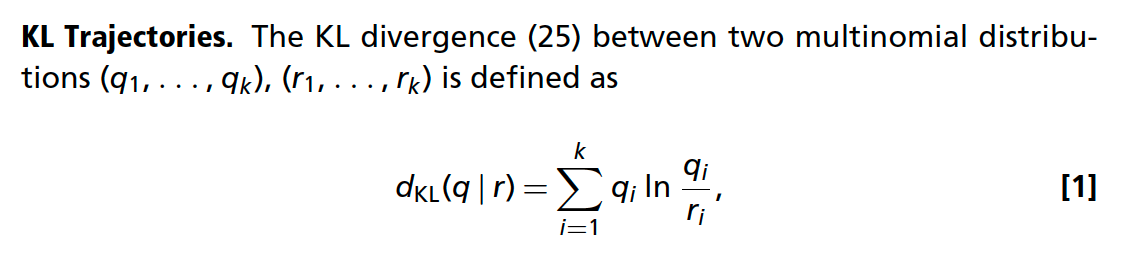

In the equation for KL divergence - taken from Olteanu et al (2019) see equation above - q and r are two multinomial distributions.

In Cécile's code, these objects are represented in the form of:
- **q = cumul_proportions** - at each observation, the proportion of each culmulative group out of the culmulative total population
- **r = ordered_proportions** - the proportions (percentages) of each group represented in the data, placed into an ordered list

### `cumul_proportions` (q)
The code for this is eventually:

`cumul_proportions = cumul_pop / sum_cumul_pop[:,np.newaxis]`

Those objects need to be created first though.

#### `cumul_pop`
This command culmulates the data at the group level.

For example, as the first number in each list is the white count. The white count for the first 3 output areas as 359, 248 and 273:
* In row 1, the first number in the list is 359 (culmulative of observation number 1)
* In row 2, the first number in the list is 607 (culmulative of observation numbers 1 and 2, i.e 359 + 248)
* In row 3, the first number in the list is 880 (culmulative of observation numbers 1, 2 and 3, i.e 359 + 248 + 273)

In [11]:
cumul_pop = np.cumsum(leic_eth_population_matrix, axis=0)

cumul_pop

array([[   359.,     11.,     25.,     18.,      0.],
       [   607.,     36.,     75.,     53.,      1.],
       [   880.,     48.,    103.,     59.,     16.],
       ...,
       [166229.,  11535., 122049.,  20503.,   8540.],
       [166301.,  11554., 122299.,  20532.,   8556.],
       [166636.,  11580., 122470.,  20585.,   8568.]])

#### `sum_cumul_populations`
This command culmulates the number of residents in each observation (output area).

For example, the first number in the list is 413 - this is the total number of residents in the first output area (i.e 359 + 11 + 25 + 18 + 0)

The second number in the list is 772 - which is 413 + 359. The total number of residents in the second output area is 359 (i.e 248 + 25 + 50 + 35 + 1)

In [12]:
sum_cumul_pop = np.sum(cumul_pop, axis=1)

sum_cumul_pop[:5]

array([ 413.,  772., 1106., 1386., 1706.])

This output can be then changed slightly using the `[:,np.newaxis]` code, which converts the `sum_cumul_pop` output so that the addition of each output area to the culmulation is placed on a new row.

This is useful when we put it all together - as shown below.

In [13]:
sum_cumul_pop[:,np.newaxis][:5]

array([[ 413.],
       [ 772.],
       [1106.],
       [1386.],
       [1706.]])

#### Putting it together
The command to bring this all together makes use of the `[:,np.newaxis]` command, to ensure that the number of rows in both datasets is the same - meaning that each group is compared against the respective total culmulative value.

Therefore, this command - `cumul_proportions` - is the proportion of each culmulative group out of the culmulative total population.

For example, the first row of data is:

* $0.8692$ = $359 \over 413$ = ${culmulative \space white} \over {culmulative \space total}$


* $0.0266$ = $11 \over 413$ = ${culmulative \space mixed} \over {culmulative \space total}$


* $0.0605$ = $25 \over 413$ = ${culmulative \space asian} \over {culmulative \space total}$


* $0.0435$ = $18 \over 413$ = ${culmulative \space black} \over {culmulative \space total}$


* $0$ = $0 \over 413$ = ${culmulative \space other} \over {culmulative \space total}$

The second row of data is:

* $0.7862$ = $607 \over 772$ = ${culmulative \space white} \over {culmulative \space total}$


* $0.0466$ = $36 \over 772$ = ${culmulative \space mixed} \over {culmulative \space total}$


* $0.0971$ = $75 \over 772$ = ${culmulative \space asian} \over {culmulative \space total}$


* $0.0686$ = $53 \over 772$ = ${culmulative \space black} \over {culmulative \space total}$


* $0.0012$ = $1 \over 772$ = ${culmulative \space other} \over {culmulative \space total}$

And so on

In [14]:
cumul_proportions = cumul_pop / sum_cumul_pop[:,np.newaxis]

cumul_proportions

array([[0.86924939, 0.02663438, 0.06053269, 0.04358354, 0.        ],
       [0.78626943, 0.04663212, 0.09715026, 0.06865285, 0.00129534],
       [0.79566004, 0.04339964, 0.09312839, 0.05334539, 0.01446655],
       ...,
       [0.50547656, 0.03507614, 0.37113205, 0.06234644, 0.02596881],
       [0.50510263, 0.03509273, 0.37145625, 0.06236142, 0.02598696],
       [0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631]])

### `ordered_proportions` (r)
This comes from the `theoretical_max_distortion` function - that is also within the *segregation_distortion.py* document

The code is:

`ordered_proportions = sorted(demographics.global_statistics)`

- The `global_statistics` object comes from the demographics class within the *basic_analysis.py* document
- It is created using `global_statistics = sum_pop_group / total_pop`

#### sum_pop_group and total_pop

So, looking firstly at the global statistics command - this uses two objects:
- `sum_pop_group` - this aggregates the total population of each group, using the population matrix we created in step 2. This can be seen below

This output is in the order white, mixed, asian, black and other

In [15]:
sum_pop_group = np.sum(leic_eth_population_matrix, axis=0)

sum_pop_group

array([166636.,  11580., 122470.,  20585.,   8568.])

- `total_pop` - again using our population matrix, this outputs the total population of our population matrix

i.e there are **329,839** people in Leicester, according to this record

In [16]:
total_pop = np.sum(leic_eth_population_matrix)

total_pop

329839.0

#### global_statistics

The `global_statistics` therefore represents the proportion of the population identified by each group

i.e according to this record, **50.52%** of Leicester's population are white

In [17]:
global_statistics = sum_pop_group/total_pop

global_statistics

array([0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631])

The **`ordered_proportions`** therefore take these proportions from `global_statistics` and put then in a sorted order.

As you can see from the output, they are sorted from a list array to one ascending column.

In [18]:
ordered_proportions = sorted(global_statistics)

ordered_proportions

[0.025976309654103972,
 0.035108037557717554,
 0.062409236021210346,
 0.37130236266784705,
 0.5052040540991211]

## Step 4 - Ordering `leic_eth_population_matrix` by distance

### Where we're going - the KL divergence profile equation

To complete the whole equation - we need the to use **`cumul_proportions` (q)** and **`ordered_proportions` (r)** in an equation together to calculate the KL divergence profile. Within this equation is included a calculation of the natural logrithm of `cumul_proportions` divided by `ordered_proportions`.

$$ ln \left( {{q_i} \over {r_i}} \right) = ln \left( {{{{cumulative \_ proportions}\space_i}} \over {{ordered \_ proportions}\space_i}} \right) $$

In Cécile's code, this is done in two steps, in the following:

`relative_cumul_proportions = cumul_proportions / ordered_proportions`

`log_relative_cumul = np.log(relative_cumul_proportions)`

#### Problems with infinity

However, creating this calculation from scratch has issues in relation to this natural logarithms equation. Notably when dealing with zero values.

The natural logarithm of zero is approximated to negative infinity:

$$ln \left( 0 \right) \approx - \infty $$

Within a function - it is important that reponses you get are usable. Negative infinity is not in any way usable or useful to us, in relation to the population statistic we are trying to create.

In her code, Cécile resolves this mathematical quandry by including the following line of code within her function - substituting these negative infinity results with zero:

`log_relative_cumul[log_relative_cumul == -math.inf] = 0`

#### Solution - Using `scipy.special.rel_entr`

While this methodology is sound, I have been recommended to use the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function to carry out the whole equation listed on the Olteanu et al (2019) paper to calculate the KL divergence profile (which is also referred to as relative entropy). It takes in the *q* and *r* objects as an array, and returns the relative entropy.

Within the [reference material](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) for this function, you can see that the equation being calculated is exactly the same as in the Olteanu et al. paper - with the only extra functionality that if either $x = 0 \space \text{or} \space y = 0$ then the 'relative entropy' returned is 0, which resolves the issue of our equation outputting negative infinity.

### Why do we need a distance matrix?

For this to be useful in calculating a divergence profile over space, I first need to be able to sort the geographical units in terms of their proximity to some chosen central point for the analysis. To do this, I can first use the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) function to create a matrix of distance between each geographical unit and the chosen central point. I can then sort the geographical units with repect to this distance, and will be able to complete this KL divergence profile with respect to proximity.

If that sounds complicated, hopefully following it through, step by step, will make things clearer.

### Using `scipy.spatial.distance_matrix`
As stated above, I can use the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) to create a matrix of the distances between each point.

In my context, this is incredibly useful for being able to find the calculate the distances between all of the Output Areas (OAs). I can then undertake the divergence profile on the data, when ordered by proximity to one of these OAs, and hence have a spatially-relevant KL divergence profile.

Given that I currently have the location information of OAs as their whole geometry, I first need to create coordinates as a point of reference, from which to measure this distance.

To do this, I am going to find the [centroid](https://en.wikipedia.org/wiki/Centroid) (central point - or arithmetic mean of points) of each OA, using the *geopandas* [`GeoSeries.centroid`](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.centroid.html) command.

This has then been saved as **oa_centroids**

In [19]:
oa_centroids = leicester_ethnicity.geometry.centroid

oa_centroids

0      POINT (458352.490 307530.587)
1      POINT (458781.908 307161.265)
2      POINT (458530.851 307158.333)
3      POINT (458132.269 306870.034)
4      POINT (458905.416 306739.221)
                   ...              
964    POINT (456480.951 306507.987)
965    POINT (461943.370 305928.943)
966    POINT (458277.707 303907.173)
967    POINT (461583.353 306057.348)
968    POINT (458198.005 303928.443)
Length: 969, dtype: geometry

GeoSeries objects are a little difficult to index (extract information from). You can see that each 'POINT' has two distinct values, that represent the coordinates of the central point of each OA. To make them easy to use, I would prefer this information to be in an array, with one column representing the latitude and longitude (x and y) of each centroid.

Fortunately, an object created using `centroid` can have its coordinates plucked out using the `.x` and `.y` functionality. You can see that the code below outputs the x coordinate (left hand column) for observation with the index of 0 (the first observation/row of the oa_centroids object).

In [20]:
oa_centroids.x[0]

458352.4896059748

Therefore, using the `np.column_stack` command, I can assign a two column array to output the coordinates of the centroids of each OA.

In [21]:
oa_coords = np.column_stack((oa_centroids.x, oa_centroids.y))

oa_coords

array([[458352.48960597, 307530.58680903],
       [458781.90779248, 307161.26530351],
       [458530.85131285, 307158.33311064],
       ...,
       [458277.70694466, 303907.17345114],
       [461583.3532046 , 306057.34838906],
       [458198.00466388, 303928.44310561]])

Finally, I can now get around to using the `distance_matrix` command, to calculate the '[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)' (straight-line distance, Pythagorean distance, call it what you want) between the centroid of each and every OA in Leicester! I have input the *oa_coords* object into this command twice because I want to measure the distance between each OA and every other OA, this object contains the beginning and end of each distance measurement.

As a result of this input, you will be able to see zero values within the *oa_d_matrix* object - which represent the distance measured between each centroid and itself.

This gives you an idea of how this function is operating, iterating through each point, first measuring the distance between point 0 on input 1 (oa_coords) and and point 0 on input 2 (also oa_coords). Hence why the first value of the first row of the output is 0.

The function has then measured the distance between point 0 on input 1 to point 1 on input 2, which is measured as *566.39...* units. This can be seen on the second value of the first row. But, it can be also seen on the first value of the second row, which represents the distance measured between point 1 on input 1 and point 0 on input 2. As both the inputs are the same, you will be able to see these mirrored/duplicated figures throughout the dataset. It is good news they are present, and shows you that the command is working as it should.

In [22]:
oa_d_matrix = distance_matrix(oa_coords, oa_coords)

oa_d_matrix

array([[   0.        ,  566.3906367 ,  412.77804501, ..., 3624.18498542,
        3550.90284787, 3605.45487525],
       [ 566.3906367 ,    0.        ,  251.07360219, ..., 3292.92154151,
        3011.10095332, 3285.13047334],
       [ 412.77804501,  251.07360219,    0.        , ..., 3261.00003108,
        3244.98615656, 3246.99497018],
       ...,
       [3624.18498542, 3292.92154151, 3261.00003108, ...,    0.        ,
        3943.41849916,   82.4915254 ],
       [3550.90284787, 3011.10095332, 3244.98615656, ..., 3943.41849916,
           0.        , 3999.10270537],
       [3605.45487525, 3285.13047334, 3246.99497018, ...,   82.4915254 ,
        3999.10270537,    0.        ]])

Below I have selected the first 24 distance measurements from point 0 in *oa_coords* - it is clear that they have not been ordered, but instead represent the distance between the first point of input 1 and first 24 points from input 2.

In [23]:
oa_d_matrix[0,:24]

array([   0.        ,  566.3906367 ,  412.77804501,  696.29514464,
        965.39546449, 1033.10512064, 1211.53527928,  913.74252203,
       1291.78393035,  852.15070031,  415.4250758 ,  920.56203678,
        418.23274714,  455.00643148,  659.74227111,  732.99644795,
        201.02294776,  196.45014637,  569.68086007,  428.43385495,
        217.40594256,  460.43741361,   99.84874874,  565.86062144])

I now need to establish a methodology for sorting the output of the distance matrix, such that I can create a proximity-ordered input for the KL divergence equation.

The `argsort` function from the *NumPy* library is able to do what I want. However, you will note that where I have inputted the distance measurements from point 0 (hence the *[0]*) that the *sorted_indices_obs0* output does not return an ordered array of the distance values, but instead returning the indices (position in the array) that corresponds to the increasing distance values.

Below you can see that the `argsort` function establishes that the lowest value in *oa_d_matrix* is observation 0 - which corresponds to the distance between point 0 and itself - so far so good. The second lowest value - which corresponds to the OA with the closest centroid to point 0 - is found at observation 22.

So the OA represented by observation 22 is the closest OA to our reference OA, point 0. Then, the second closest OA is observation 17, third closest is observation 16, and so on.

In [24]:
sorted_indices_obs0 = np.argsort(oa_d_matrix[0])

sorted_indices_obs0[:20]

array([ 0, 22, 17, 16, 20, 26, 24,  2, 25, 10, 12, 19, 13, 21, 23,  1, 18,
       29, 42, 40])

I can test out the output of `argsort` by indexing (pulling out) the distance figures represented from the observations it lists as closest to point 0.

Below you can see that:
- Observation 22 is listed as *99.84...* units from point 0
- Observation 17 is listed as *196.45...* units from point 0
- Observation 16 is listed as *201.02...* units from point 0
- Observation 20 is listed as *217.40...* units from point 0

So it seems that `argsort` has done its job - we have a way of finding the closest OAs to our reference of point 0.

In [25]:
oa_d_matrix[0, [0, 22, 17, 16, 20]]

array([  0.        ,  99.84874874, 196.45014637, 201.02294776,
       217.40594256])

To do the previous step in a more efficient way, we can input our *sorted_indices_obs0* as the indexing input. This saves us writing them all out by hand. Here I've selected the first 20.

In [26]:
oa_d_matrix[0, sorted_indices_obs0][:20]

array([  0.        ,  99.84874874, 196.45014637, 201.02294776,
       217.40594256, 325.55581094, 359.75156182, 412.77804501,
       413.75356582, 415.4250758 , 418.23274714, 428.43385495,
       455.00643148, 460.43741361, 565.86062144, 566.3906367 ,
       569.68086007, 576.47296505, 640.02582031, 649.92765025])

But what if I want to know the distances from a different OA? Well I can actually get to our ordered distances matrix in one line of code, by combining all of our previous steps together.

Instead of point 0 in our first example, lets choose a completely random number to look at... point 425 in the observed OAs.

To find our distance matrix, you can do the following:

In [27]:
oa_d_matrix[425, np.argsort(oa_d_matrix[425])][:20]

array([  0.        , 202.47326134, 205.10376477, 260.76175512,
       311.23760685, 312.45522627, 322.11656464, 350.87726699,
       364.41809331, 424.00049742, 425.78792883, 430.05702551,
       447.64502897, 477.63295736, 481.71413063, 517.04595294,
       543.67952058, 577.06157476, 599.61158882, 600.00705389])

This therefore tells us that - for point 425:
- The closest OA is *202.47...* units away
- The second closest OA is *205.10...* units away
- The third closest OA is *260.76...* units away

## Step 5 -  Creating *q* and *r* objects for `leic_eth_population_matrix` ordered by our distance matrix, `oa_d_matrix`

Lets recap.

We have just successfully created a distance matrix - `oa_d_matrix` - that contains the distances between the centre of each point (geographical unit), and the centre of every other point.

We have then established how to order this distance matric - to do this we are originally returned with the indices (numerical positions of the value) in order of increasing distance away from our central point. But we can then use this selection of indices to return us an ordered matrix of the distances from each point.

Now we have a way of inputting our data into the KL divergence profile equation in a meaningful way, in order of distance away from our central point. This is the basic premise of the KL divergence profile, which I've fleshed out in a bit more detail in my first blog post, accompanying this project: [https://noahbouchier.github.io/blog/gsoc/gsoc-intro/#what-am-i-doing](https://noahbouchier.github.io/blog/gsoc/gsoc-intro/#what-am-i-doing)

While I hope to eventually be calculating the KL divergence profile for every single point. To trial this technique out - I'm going to be calculating every step in relation to point 0, to keep things straightforward. Therefore I'll be sorting the population matrix just as I did above, using the ***sorted_indices_obs0*** object. This object shows the indices of the OAs, in ascending distance from the centre of point 0.

#### Sorting *leic_eth_population matrix* by the indices from *oa_d_matrix*

So lets recap what *sorted_indices_obs0* represents. It has been made using the `np.argsort` function to find the indices of the observations that are located in increasing distance away from our point 0.

The output below shows that point 22 is the closest OA to that of point 0 - followed by point 17, point 16, point 20, and so on.

In [28]:
# sorted_indices_obs0 = np.argsort(oa_d_matrix[0])

sorted_indices_obs0[:20]

array([ 0, 22, 17, 16, 20, 26, 24,  2, 25, 10, 12, 19, 13, 21, 23,  1, 18,
       29, 42, 40])

For our `cumul_proportions` (*q*) and `ordered_proportions` (*r*) objects, we need to be able to input our demographic data - of the number of each ethnic group - ordered using our distance matrix. So lets make sure we know how to output this first. This follows a very similar process to how we were able to index our distance matrix, to output an ordered matrix of distances.

If we manually find the first 5 values we should get from our sorted matrix, then we can confirm it works as it should. So lets output the ethnicity values for points *0, 22, 17, 16* and *20*.

In [29]:
leic_eth_population_matrix[0]

array([359.,  11.,  25.,  18.,   0.])

In [30]:
leic_eth_population_matrix[22]

array([192.,  14.,  20.,  33.,   2.])

In [31]:
leic_eth_population_matrix[17]

array([267.,   5.,  17.,   4.,   1.])

In [32]:
leic_eth_population_matrix[16]

array([206.,   5.,  40.,  37.,   1.])

In [33]:
leic_eth_population_matrix[20]

array([187.,   6.,  10.,  26.,   1.])

Then, we can compare those outputs to the first 5 values we get when we index the population matrix using our *sorted_indices_obs0*.

(if you can't find that in this next line of code, it's because I've substituted it for the whole line of code that forms it - this makes it easier to compare to our next tests)

In [34]:
leic_eth_population_matrix[np.argsort(oa_d_matrix[0])][:5]

array([[359.,  11.,  25.,  18.,   0.],
       [192.,  14.,  20.,  33.,   2.],
       [267.,   5.,  17.,   4.,   1.],
       [206.,   5.,  40.,  37.,   1.],
       [187.,   6.,  10.,  26.,   1.]])

As you can see, these first 5 observations are exactly as we hoped they would be above. I love it when a plan comes together.

##### Testing for points 1 and 2

To be certain that this works on a wider scale, when we're looking at more than just point 0 - we can repeat the same tests we just did, but for points 1 and 2.

With each we find the indices of the first 3 points, then output the demographic data for those 3 points. Then we can attempt to output this as part of the population matrix, that we have ordered by distance. Essentially this is a good test of how our indexing is working.

Here we are for point 1:

In [35]:
np.argsort(oa_d_matrix[1])[:3]

array([ 1, 28, 24])

In [36]:
leic_eth_population_matrix[1]

array([248.,  25.,  50.,  35.,   1.])

In [37]:
leic_eth_population_matrix[28]

array([134.,  20.,  40.,  28.,   3.])

In [38]:
leic_eth_population_matrix[24]

array([185.,  14.,  69.,  13.,   0.])

In [39]:
leic_eth_population_matrix[np.argsort(oa_d_matrix[1])][:3]

array([[248.,  25.,  50.,  35.,   1.],
       [134.,  20.,  40.,  28.,   3.],
       [185.,  14.,  69.,  13.,   0.]])

And for point 2:

In [40]:
np.argsort(oa_d_matrix[2])[:3]

array([ 2, 24, 29])

In [41]:
leic_eth_population_matrix[2]

array([273.,  12.,  28.,   6.,  15.])

In [42]:
leic_eth_population_matrix[24]

array([185.,  14.,  69.,  13.,   0.])

In [43]:
leic_eth_population_matrix[29]

array([153.,   8., 189.,  15.,   9.])

In [44]:
leic_eth_population_matrix[np.argsort(oa_d_matrix[1])][:3]

array([[248.,  25.,  50.,  35.,   1.],
       [134.,  20.,  40.,  28.,   3.],
       [185.,  14.,  69.,  13.,   0.]])

And this can all be seen in the whole matrix, by running the command below.

You can see each observation, contained using *[ ]* brackets - with the population figures for points 0, 1 and 2 shown consecutively. This confirms to use that this line of code successfully sorts the whole population matrix as we wish it to, and that we know where it has come from.

In [45]:
leic_eth_population_matrix[np.argsort(oa_d_matrix, axis = 0)]

array([[[359.,  11.,  25.,  18.,   0.],
        [248.,  25.,  50.,  35.,   1.],
        [273.,  12.,  28.,   6.,  15.],
        ...,
        [129.,  12.,  73.,  23.,   4.],
        [ 72.,  19., 250.,  29.,  16.],
        [335.,  26., 171.,  53.,  12.]],

       [[192.,  14.,  20.,  33.,   2.],
        [134.,  20.,  40.,  28.,   3.],
        [185.,  14.,  69.,  13.,   0.],
        ...,
        [335.,  26., 171.,  53.,  12.],
        [105.,  14., 158.,  33.,  11.],
        [129.,  12.,  73.,  23.,   4.]],

       [[267.,   5.,  17.,   4.,   1.],
        [185.,  14.,  69.,  13.,   0.],
        [153.,   8., 189.,  15.,   9.],
        ...,
        [ 77.,  13.,  83.,  21.,  26.],
        [171.,  15., 153.,  36.,   1.],
        [343.,  13.,  83.,  26.,  35.]],

       ...,

       [[283.,   6.,   5.,  11.,   1.],
        [283.,   6.,   5.,  11.,   1.],
        [283.,   6.,   5.,  11.,   1.],
        ...,
        [137.,  25., 124.,  19.,  70.],
        [201.,   8.,   8.,   5.,   0.],
        [

#### Creating *q* - `cumul_proportions`

Here we can create our *q* object - culmulative proportions, as in step 3 - however this time instead of inputting our population matrix, we are inputting our population matrix that has been ordered by distance from point 0. Each command has therefore been given the prefix *'p0'* to represent that this is the calculation solely for point 0.

As a result - `leic_eth_population_matrix` has been replaced with `leic_eth_population_matrix[np.argsort(oa_d_matrix[0])]`.

`p0_cumul_pop` is a matrix where each row is a culmulative population for each group.

In [46]:
p0_cumul_pop = np.cumsum(leic_eth_population_matrix[np.argsort(oa_d_matrix[0])], axis = 0)

p0_cumul_pop

array([[   359.,     11.,     25.,     18.,      0.],
       [   551.,     25.,     45.,     51.,      2.],
       [   818.,     30.,     62.,     55.,      3.],
       ...,
       [166137.,  11553., 122461.,  20583.,   8565.],
       [166416.,  11570., 122468.,  20585.,   8567.],
       [166636.,  11580., 122470.,  20585.,   8568.]])

To check this has all worked correctly, I'll be seeing if all the numbers add up. For point 0, and its two closest OAs, their number of white population are 359, 192 and 267 consecutively. Therefore, when I add them up, they should relate to the first number in each row.

In [47]:
359 + 192

551

In [48]:
359 + 192 + 267

818

They do - great!

Next, I can calculate the the `p0_sum_cumul_pop` - which is the culmulative population, aggregating by point as the distance increases away from point 0.

This command just includes the `[:,np.newaxis]` switch as part of the object creation

In [49]:
p0_sum_cumul_pop = np.sum(p0_cumul_pop, axis=1)[:,np.newaxis]

p0_sum_cumul_pop[:5]

array([[ 413.],
       [ 674.],
       [ 968.],
       [1257.],
       [1487.]])

Now we can test this again - to ensure that I'm getting the right numbers.

Looking back to when we our sorted population matrix - we can see that the first 3 sets of demographic information are:
* `359, 11, 25, 18, 0` for point 0
* `192, 14, 20, 33, 2` for point 22
* `267, 5, 17, 4, 1`  for point 17

So lets see if they aggregate to give us what we have found.

In [50]:
(359 + 11 + 25 + 18 + 0)

413

In [51]:
(359 + 11 + 25 + 18 + 0) + (192 + 14 + 20 + 33 + 2)

674

In [52]:
(359 + 11 + 25 + 18 + 0) + (192 + 14 + 20 + 33 + 2) + (267 + 5 + 17 + 4 + 1)

968

Exactly as we have seen in out `p0_sum_cumul_pop` output.

We can then divide one by the other to create our `p0_cumul_proportions` object

In [53]:
p0_cumul_proportions = p0_cumul_pop / p0_sum_cumul_pop

p0_cumul_proportions

array([[0.86924939, 0.02663438, 0.06053269, 0.04358354, 0.        ],
       [0.81750742, 0.03709199, 0.06676558, 0.07566766, 0.00296736],
       [0.84504132, 0.03099174, 0.06404959, 0.05681818, 0.00309917],
       ...,
       [0.50451717, 0.03508362, 0.37188391, 0.0625055 , 0.0260098 ],
       [0.50489372, 0.03510252, 0.37155877, 0.06245335, 0.02599164],
       [0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631]])

Then - just for fun - check that these numbers align.

This is the number of white population in point 0 divided by the total population in point 0.

In [54]:
359 / 413

0.8692493946731235

So the white population accounts for **86.9%** of the total population in point 0.

This is the number of white population in point 0 and point 22 divided by the total population in point 0 and point 22.

In [55]:
551 / 674

0.8175074183976261

So the white population accounts for **81.75%** of the total population in points 0 and 22.

This is the number of white population in point 0, point 22 and point 17 divided by the total population in point 0, point 22 and point 17.

In [56]:
818 / 968

0.8450413223140496

So the white population accounts for **84.5%** of the total population in points 0, 22 and 17.

#### Creating *r* - `ordered_proportions`

Here we can create our *r* object - ordered proportions, as in step 3 - however this time again instead of inputting our population matrix, we are inputting our population matrix that has been ordered by distance from point 0. Each command has therefore been given the prefix *'p0'* to represent that this is the calculation solely for point 0.

As a result - `leic_eth_population_matrix` has been replaced with `leic_eth_population_matrix[np.argsort(oa_d_matrix[0])]`.

Firstly, we create the objects required to undertake the equation to form our *global_statistics* object - `global_statistics = sum_pop_group / total_pop`

`p0_sum_pop_group` gives us the total population for each group, throughout the whole dataset.

In [57]:
p0_sum_pop_group = np.sum(leic_eth_population_matrix[np.argsort(oa_d_matrix[0])], axis=0)

p0_sum_pop_group

array([166636.,  11580., 122470.,  20585.,   8568.])

As a result, this is the same as for all observations. You can see this if we pick another random observation (well our old friend point 425 again) - the output is exactly the same.

In [58]:
np.sum(leic_eth_population_matrix[np.argsort(oa_d_matrix[425])], axis=0)

array([166636.,  11580., 122470.,  20585.,   8568.])

`p0_total_pop` gives us the total population of the entire dataset. 

In [59]:
p0_total_pop = np.sum(leic_eth_population_matrix[np.argsort(oa_d_matrix[0])])

p0_total_pop

329839.0

Again, it doesn't matter which point this in relation to. This can be seen by the fact that we get the same result when we instead look at point 425.

In [60]:
np.sum(leic_eth_population_matrix[np.argsort(oa_d_matrix[425])])

329839.0

We then put these two objects together to find our `p0_global_statistics`

In [61]:
p0_global_statistics = p0_sum_pop_group / p0_total_pop

p0_global_statistics

array([0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631])

These results tell us that the white population represent **50.52%** of Leicester's population.

We can then create the `p0_ordered_proportions` by sorting these values

In [62]:
p0_ordered_proportions = sorted(p0_global_statistics)

p0_ordered_proportions

[0.025976309654103972,
 0.035108037557717554,
 0.062409236021210346,
 0.37130236266784705,
 0.5052040540991211]

Essentially - when calculating our *ordered_proportions* we don't neccessarily *need* the data sorted by distance. However, there is also no harm in feeding in the sorted data either.

### Feeding this into the `scipy.special.rel_entr` function

This is the final step to calculate the KL divergence profile - the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) makes computing this very straight forward, solving all the issues discussed at the start of step 4 in relation to negative infinity.

The `scipy.special.rel_entr` function takes in two inputs - $x$ and $y$ - where they relate to the equation for this function in the following way.

$$ x \space ln \left( {{x} \over {y}} \right) = {{cumulative \_ proportions}\space_i} \space ln \left( {{{{cumulative \_ proportions}\space_i}} \over {{ordered \_ proportions}\space_i}} \right) $$

Therefore, we can input our *p0_cumul_proportions* and *p0_ordered_proportions* in the following way:

In [63]:
scipy.special.rel_entr(p0_cumul_proportions, p0_ordered_proportions)

array([[ 3.05145229, -0.00735714, -0.00184805, -0.09337063,  0.        ],
       [ 2.81964442,  0.00203898,  0.00450497, -0.12036196, -0.01524418],
       [ 2.94260338, -0.00386496,  0.00166172, -0.10665684, -0.01578665],
       ...,
       [ 1.49660827, -0.00002441,  0.66376386, -0.11136994, -0.07715778],
       [ 1.49810197, -0.00000552,  0.66285853, -0.11132915, -0.07712207],
       [ 1.4993332 ,  0.        ,  0.66214478, -0.11129461, -0.07709191]])

And there we have it - the outputs of the first attempt at a KL divergence matrix, finding how the ethnic composition of the city of Leicester changes - in relation to the total city population - as you radiate out from point 0.

## Step 6 - Creating a loop to run the KL divergence profile

Now I need to find a method that cycles through the rest of the points all in one go!

The most straightforward way of doing this would be to build a loop that cycles through all of the steps to calculate the divergece profile for one point, and then output from `scipy.special.rel_entr` function in one big dataframe.

The following is such a loop, that is attempting to run through the whole sequence of commands required to calculate the the KL divergence profile. This uses the rough methodology we have ended up at during the first 5 steps of this workbook.

For the moment - to make this whole process easier - I am going to presume that the inputted data is as the population matrix that we have created in Step 2.

i.e of the form `leic_eth_population_matrix`

This particular loop  is only going through the first 4 points (point 0, 1, 2 and 3), outputting the culmulative group information for the first 2 iterations (for the point itself and then culmulative with the next closest point to it.

### Structure of the loop

As a result, the structure of the loop should be the following:

#### Creating a distance matrix
* Finding the coordinates for the centroids of each geographical unit
* Using `scipy.spatial.distance_matrix` - Creating a matrix that holds the distance between each unit and every other unit

#### Creating the *q* and *r* objects
* Creating the cumulative proportions for each group from the total population - which is our ***q*** object
* Creating the ordered proportions for each population from the total population - which is our ***r*** object

#### Calculating the KL divergence profile
* Using `scipy.special.rel_entr` - Calculating the relative entropy, using the *q* and *r* objects

In [64]:
for i in range(4):
    
    # Creating a distance matrix
    
    centroids = leicester_ethnicity.geometry.centroid
    
    centroid_coords = np.column_stack((centroids.x, centroids.y))
    
    dist_matrix = distance_matrix(centroid_coords, centroid_coords)
    
    # Creating the q and r objects
    
    cumul_pop = np.cumsum(leic_eth_population_matrix
                          [np.argsort(dist_matrix[i])], axis = 0)
    
    sum_cumul_pop = np.sum(cumul_pop, axis = 1)[:,np.newaxis]
    
    q_cumul_proportions = cumul_pop / sum_cumul_pop
    
    sum_pop_group = np.sum(leic_eth_population_matrix, axis = 0, keepdims = True)
    
    total_pop = np.sum(leic_eth_population_matrix)
    
    global_statistics = sum_pop_group / total_pop
    
    r_ordered_proportions = global_statistics
    
    # Calculating the KL divergence profile
    
    kl_div_profile = scipy.special.rel_entr(q_cumul_proportions, r_ordered_proportions).sum(axis = 1)

    # Print out the results

    print(i)
    
    print(kl_div_profile)

0
[0.33891223 0.28908369 0.30636392 0.26434178 0.27422422 0.2289333
 0.1957335  0.19478594 0.20900763 0.21166903 0.19992458 0.19338632
 0.20281823 0.21186454 0.21776736 0.21186113 0.22001706 0.17642812
 0.17831267 0.18291868 0.18079665 0.16869785 0.15082893 0.15523349
 0.15290587 0.15761319 0.16016517 0.13817061 0.13904675 0.14123526
 0.1436015  0.13668649 0.12051147 0.12202547 0.12672961 0.12090279
 0.11192918 0.11420568 0.11382447 0.11654786 0.11936292 0.10265801
 0.09944765 0.10103911 0.10406109 0.10496598 0.10256991 0.09572961
 0.08869489 0.08135231 0.08298176 0.07799326 0.07996559 0.08074537
 0.08051688 0.08093574 0.07245488 0.06434941 0.06731206 0.06945465
 0.06367335 0.06130738 0.05273921 0.05533709 0.05652784 0.05672048
 0.04915801 0.043831   0.04491084 0.03986366 0.03305621 0.02848757
 0.0236641  0.02420929 0.02224188 0.01678432 0.01703512 0.0179821
 0.01514415 0.01312357 0.01120641 0.00933658 0.00960111 0.0097563
 0.00995683 0.01016931 0.0107276  0.00861992 0.00681087 0.00671

2
[0.27154031 0.13853584 0.02913939 0.04187595 0.04722193 0.06270372
 0.06605356 0.07395561 0.09533701 0.06198354 0.07814875 0.06278647
 0.0661218  0.0739355  0.07822837 0.07942301 0.08730749 0.06812853
 0.06425135 0.07244301 0.06331077 0.06982246 0.05768691 0.06447847
 0.06154878 0.06486548 0.04976317 0.0506723  0.048809   0.04289528
 0.04577691 0.03574235 0.04104117 0.04371981 0.04427908 0.0390468
 0.02832975 0.0258976  0.02546514 0.02132678 0.02143847 0.02282528
 0.02475882 0.02709504 0.02180289 0.02423387 0.01751857 0.01213996
 0.0136476  0.01540802 0.00949909 0.01041972 0.0089526  0.00656853
 0.00643545 0.00498639 0.00420198 0.00351692 0.00385572 0.00411994
 0.00345409 0.00342387 0.00352573 0.00370976 0.00372837 0.00402346
 0.00402522 0.00409255 0.00402548 0.00371358 0.00380827 0.00360885
 0.00380101 0.00389051 0.00366109 0.00379359 0.0041401  0.00400455
 0.00448322 0.0048634  0.00579314 0.00703604 0.00797054 0.00929372
 0.01060238 0.01213319 0.01281387 0.01500594 0.01588569 0.014

So there we have the KL divergence profiles for the first four observations, outputted in one fell loop!!

By way of interpretting the beginning of the output, you can see the first list is in relation to *point 0* (hence the 0 before the bracketed output)

This list gives the divergence outputs.

* The first number - *0.3389* - gives the divergence metric between point 0 and the total population
* The second number - *0.2890* - gives the divergence metric between:
    * the accumulation of point 0 and its next closest point (which we know to be point 22) and
    * the total population
* The third number - *0.3063* - gives the divergence metric between:
    * the accumulation of point 0 and its closest two points (which we know to be points 22 then 17) and
    * the total population

The list continues, moving outwards from point 0. If you trawl through the rest of that list, to show the divergence metrics, you will see that there is a general pattern of these values decreasing. This makes sense, as it is more likely that as more of the population is agglomerated, it will become more like the global population of Leicester, unless point 0 happens to be incredibly representative of Leicester on the whole.

However, there are times when the divergence metric increases, even though the population being included within this calculation has increased. This would suggest that as a collective, the population is getting less representative of Leicester as a whole. In turn, this would suggest that the point that has just been added to the mix is one that is particularly unrepresentative of Leicester. In this context, given Leicester is considered diverse and multicultural, this could mean that the point added has an anomalously high concentration of a single ethnicity.

To see the divergence metric increase consecutively suggests that there is a collection of particularly anomalous points, clustered within a similar distance from point 0.

As you can see, the output of this loop is already able to help us better understand the population of Leicester. However, it can be much easier to interpret this information if it is displayed in a more digestable way.

This is therefore our next task, to display the data in some handy formats - including as a table and understand how to use this output in graphics.

## Step 7 - Improving the loop

While this loop gives us what we need - there are definitely ways by which it can be improved. The code can be streamlined

The changes to note in this version of the loop are:
* Creating the distance matrix outside of the loop
* Creating a list to add the results of the loop to
* Change the method of beginning the loop to include `distances` and `enumerate`
* Creating `sorted_indices` - to use in *cumul_pop* as well as in the output dataframe
* Creating an object for the population within the distance (*pop_within_d*)
* Creating an output dataframe
* Append (add together) all the outputs from each i
* Create a *final_result* object that concatenate (stacks) all the dataframes on top of eachother

In [65]:
# Creating a distance matrix

centroids = leicester_ethnicity.geometry.centroid

centroid_coords = np.column_stack((centroids.x, centroids.y))

dist_matrix = distance_matrix(centroid_coords, centroid_coords)

results = [] ## save the results to a list

for (i, distances) in enumerate(dist_matrix):

    # Creating the q and r objects
    sorted_indices = np.argsort(distances)
    
    cumul_pop = np.cumsum(leic_eth_population_matrix
                          [sorted_indices], axis = 0)

    sum_cumul_pop = np.sum(cumul_pop, axis = 1)[:,np.newaxis]

    q_cumul_proportions = cumul_pop / sum_cumul_pop

    sum_pop_group = np.sum(leic_eth_population_matrix, axis = 0, keepdims=True)

    total_pop = np.sum(leic_eth_population_matrix)

    r_ordered_proportions = sum_pop_group / total_pop # remove `global statistics`

    # Calculating the KL divergence profile

    kl_div_profile = scipy.special.rel_entr(q_cumul_proportions, 
                                            r_ordered_proportions).sum(axis = 1) # add sum of each row (point)
    pop_within_d = cumul_pop.sum(axis=1)

    output = pd.DataFrame().from_dict(dict(
        observation = i,
        distance = distances[sorted_indices],
        divergence = kl_div_profile.round(decimals = 6),
        pop_within_d = pop_within_d
    ))
    
    results.append(output) ## add the output from this iteration to the output
    
    print(output)

final_result = pd.concat(results) ## concatenate all the dataframes together

     observation     distance  divergence  pop_within_d
0              0     0.000000    0.338912         413.0
1              0    99.848749    0.289084         674.0
2              0   196.450146    0.306364         968.0
3              0   201.022948    0.264342        1257.0
4              0   217.405943    0.274224        1487.0
..           ...          ...         ...           ...
964            0  8764.893857    0.000004      328771.0
965            0  8889.141852    0.000002      328993.0
966            0  8901.756684    0.000001      329299.0
967            0  8925.709227    0.000000      329606.0
968            0  8960.055913    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0              1     0.000000    0.164547         359.0
1              1   177.909969    0.143928         584.0
2              1   206.924416    0.108838         865.0
3              1   251.073602    0.123158        1199.0
4              1   279.6

     observation     distance  divergence  pop_within_d
0             38     0.000000    0.225756         314.0
1             38   154.712445    0.274747         611.0
2             38   275.650723    0.300013         952.0
3             38   369.771389    0.278735        1334.0
4             38   372.673232    0.268955        1658.0
..           ...          ...         ...           ...
964           38  9487.753262    0.000004      328771.0
965           38  9618.664191    0.000002      329077.0
966           38  9629.163328    0.000001      329299.0
967           38  9658.094935    0.000000      329532.0
968           38  9674.292526    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0             39     0.000000    0.366929         297.0
1             39   146.957774    0.362552         638.0
2             39   154.712445    0.300013         952.0
3             39   291.783187    0.282952        1276.0
4             39   344.4

     observation      distance  divergence  pop_within_d
0             76      0.000000    0.299580         315.0
1             76     97.898560    0.300647         655.0
2             76    141.248195    0.275294         871.0
3             76    364.321548    0.271964        1239.0
4             76    502.094170    0.289553        1459.0
..           ...           ...         ...           ...
964           76  10226.322341    0.000001      328624.0
965           76  10249.566760    0.000001      328872.0
966           76  10327.916230    0.000000      329247.0
967           76  10336.701832    0.000000      329503.0
968           76  10489.950875    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0             77     0.000000    0.348255         237.0
1             77   123.501639    0.329965         538.0
2             77   153.264136    0.304739         835.0
3             77   171.851042    0.297396        1144.0
4           

     observation     distance  divergence  pop_within_d
0            116     0.000000    0.286053         270.0
1            116   166.056606    0.248218         636.0
2            116   228.173690    0.252060        1023.0
3            116   237.349728    0.247437        1485.0
4            116   242.797064    0.245494        1784.0
..           ...          ...         ...           ...
964          116  8426.500772    0.000004      328771.0
965          116  8558.847828    0.000002      329077.0
966          116  8564.454917    0.000001      329299.0
967          116  8602.733543    0.000000      329532.0
968          116  8607.951024    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            117     0.000000    0.313622         368.0
1            117   144.963763    0.264628         667.0
2            117   206.885326    0.244417        1129.0
3            117   235.930194    0.263301        1674.0
4            117   318.7

     observation     distance  divergence  pop_within_d
0            151     0.000000    0.444876         401.0
1            151   145.890918    0.546329         884.0
2            151   205.058858    0.567621        1301.0
3            151   214.065656    0.299986        1663.0
4            151   274.913894    0.185222        2003.0
..           ...          ...         ...           ...
964          151  8164.185998    0.000004      328771.0
965          151  8237.063034    0.000002      328993.0
966          151  8250.756480    0.000001      329300.0
967          151  8305.866718    0.000000      329606.0
968          151  8407.202745    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            152     0.000000    0.100698         268.0
1            152   228.567690    0.219894         697.0
2            152   237.206896    0.115321        1032.0
3            152   286.551111    0.127566        1349.0
4            152   294.5

     observation     distance  divergence  pop_within_d
0            190     0.000000    0.478625         321.0
1            190   221.731118    0.450396         715.0
2            190   256.104962    0.430929        1071.0
3            190   385.116840    0.439075        1432.0
4            190   399.715149    0.401565        1738.0
..           ...          ...         ...           ...
964          190  9268.633552    0.000003      328688.0
965          190  9274.562179    0.000002      328982.0
966          190  9311.762060    0.000001      329268.0
967          190  9317.732052    0.000000      329598.0
968          190  9427.253277    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            191      0.000000    0.364292         300.0
1            191    393.931688    0.381867         646.0
2            191    428.268522    0.364346        1033.0
3            191    455.595642    0.369916        1434.0
4            191   

     observation     distance  divergence  pop_within_d
0            229     0.000000    0.186945         289.0
1            229   124.983796    0.234913         621.0
2            229   180.239766    0.250156         918.0
3            229   199.136915    0.279023        1195.0
4            229   290.523427    0.263510        1464.0
..           ...          ...         ...           ...
964          229  7319.411810    0.000001      328711.0
965          229  7341.456596    0.000000      328942.0
966          229  7514.405056    0.000000      329250.0
967          229  7549.939250    0.000000      329591.0
968          229  7845.605693    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            230     0.000000    0.097305         300.0
1            230   130.596594    0.120010         652.0
2            230   179.686673    0.135832         933.0
3            230   252.697869    0.166405        1230.0
4            230   264.4

     observation     distance  divergence  pop_within_d
0            267     0.000000    0.026323         363.0
1            267   219.541605    0.022326         750.0
2            267   252.046075    0.014400        1092.0
3            267   269.674085    0.030645        1415.0
4            267   288.308126    0.017229        1688.0
..           ...          ...         ...           ...
964          267  7901.640674    0.000003      328701.0
965          267  7903.740876    0.000002      328934.0
966          267  7946.684090    0.000001      329300.0
967          267  8011.200536    0.000000      329606.0
968          267  8141.400269    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            268     0.000000    0.056535         342.0
1            268   185.231269    0.042689         694.0
2            268   247.060121    0.049943        1128.0
3            268   252.046075    0.040523        1491.0
4            268   280.6

     observation     distance  divergence  pop_within_d
0            283     0.000000    0.194534         411.0
1            283   206.740483    0.263635         694.0
2            283   218.387749    0.226400        1013.0
3            283   249.296387    0.215650        1288.0
4            283   250.795971    0.170325        1620.0
..           ...          ...         ...           ...
964          283  7386.243311    0.000004      328548.0
965          283  7393.136360    0.000002      328935.0
966          283  7428.073550    0.000001      329114.0
967          283  7635.567092    0.000001      329473.0
968          283  7977.037133    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            284     0.000000    0.092363         320.0
1            284   134.903501    0.075930         511.0
2            284   169.943512    0.044236         891.0
3            284   181.735523    0.032756        1123.0
4            284   225.4

     observation     distance  divergence  pop_within_d
0            307     0.000000    0.041024         380.0
1            307   169.943512    0.044481         700.0
2            307   208.925721    0.031617         932.0
3            307   252.443655    0.039779        1324.0
4            307   304.158253    0.039286        1515.0
..           ...          ...         ...           ...
964          307  8008.557532    0.000004      328548.0
965          307  8030.848047    0.000002      328935.0
966          307  8079.596945    0.000001      329114.0
967          307  8283.069775    0.000001      329473.0
968          307  8624.935280    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            308     0.000000    0.019747         232.0
1            308   143.905964    0.024934         606.0
2            308   181.735523    0.031598         926.0
3            308   208.925721    0.031076        1306.0
4            308   268.1

     observation      distance  divergence  pop_within_d
0            321      0.000000    0.071710         318.0
1            321    297.399972    0.081561         687.0
2            321    332.450716    0.102069        1018.0
3            321    340.835293    0.094173        1311.0
4            321    466.163983    0.117468        1635.0
..           ...           ...         ...           ...
964          321   9717.281975    0.000003      328674.0
965          321   9720.137173    0.000002      328935.0
966          321   9823.318264    0.000001      329114.0
967          321  10007.789326    0.000001      329473.0
968          321  10350.490937    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            322     0.000000    0.054911         334.0
1            322   238.996937    0.042515         601.0
2            322   319.078238    0.097663         978.0
3            322   386.833555    0.085966        1339.0
4           

     observation      distance  divergence  pop_within_d
0            345      0.000000    0.522642         304.0
1            345    171.047981    0.470400         633.0
2            345    212.926144    0.419412        1010.0
3            345    239.921490    0.428791        1260.0
4            345    257.273033    0.432326        1557.0
..           ...           ...         ...           ...
964          345   9556.128498    0.000000      328606.0
965          345   9599.831011    0.000000      328947.0
966          345   9684.858422    0.000000      329283.0
967          345   9958.514651    0.000000      329591.0
968          345  10262.199190    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            346      0.000000    0.350565         377.0
1            346    168.854813    0.365847         706.0
2            346    210.178122    0.350634        1011.0
3            346    212.926144    0.382221        1315.0
4      

     observation      distance  divergence  pop_within_d
0            358      0.000000    0.520629         237.0
1            358    177.573429    0.544513         404.0
2            358    245.647369    0.478654         843.0
3            358    284.830007    0.456748        1189.0
4            358    345.769749    0.463693        1419.0
..           ...           ...         ...           ...
964          358  10200.995751    0.000000      328606.0
965          358  10281.461665    0.000000      328942.0
966          358  10311.645216    0.000000      329283.0
967          358  10681.780226    0.000000      329591.0
968          358  10984.741316    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            359      0.000000    0.462201         280.0
1            359    120.041388    0.474128         513.0
2            359    182.989914    0.397949         901.0
3            359    190.936209    0.415660        1134.0
4      

     observation     distance  divergence  pop_within_d
0            380     0.000000    0.407761         297.0
1            380    98.755429    0.357314         491.0
2            380   120.663351    0.367834         727.0
3            380   131.073075    0.325022        1021.0
4            380   160.879872    0.335575        1294.0
..           ...          ...         ...           ...
964          380  7379.212874    0.000003      328592.0
965          380  7384.510466    0.000002      328982.0
966          380  7451.848900    0.000001      329223.0
967          380  7465.171260    0.000000      329553.0
968          380  7500.792910    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            381     0.000000    0.106639         384.0
1            381   126.356171    0.210849         673.0
2            381   134.530613    0.199685         941.0
3            381   149.948976    0.201678        1287.0
4            381   181.4

     observation     distance  divergence  pop_within_d
0            394     0.000000    0.050451         571.0
1            394   179.231947    0.028976         935.0
2            394   252.304150    0.044485        1211.0
3            394   276.978434    0.060011        1524.0
4            394   300.383418    0.080258        1977.0
..           ...          ...         ...           ...
964          394  7128.606130    0.000004      328771.0
965          394  7261.816167    0.000002      329077.0
966          394  7264.606426    0.000001      329299.0
967          394  7307.329941    0.000000      329606.0
968          394  7308.751110    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            395     0.000000    0.180703         453.0
1            395   218.483704    0.171149         766.0
2            395   289.866476    0.093727        1130.0
3            395   300.383418    0.074576        1701.0
4            395   317.9

     observation     distance  divergence  pop_within_d
0            423     0.000000    0.290908         315.0
1            423   229.083781    0.250471         654.0
2            423   242.069449    0.091021        1005.0
3            423   250.688618    0.131065        1318.0
4            423   289.458470    0.040743        1673.0
..           ...          ...         ...           ...
964          423  8710.066808    0.000001      328526.0
965          423  8837.819038    0.000000      328942.0
966          423  9008.184445    0.000000      329283.0
967          423  9184.916064    0.000000      329591.0
968          423  9504.898536    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            424     0.000000    0.302327         453.0
1            424   184.735973    0.286812         753.0
2            424   202.473261    0.244439        1120.0
3            424   247.607059    0.264086        1445.0
4            424   281.5

     observation     distance  divergence  pop_within_d
0            439     0.000000    0.380105         278.0
1            439    80.571816    0.342241         624.0
2            439   180.653763    0.310033         935.0
3            439   202.102410    0.296619        1232.0
4            439   210.111499    0.299769        1533.0
..           ...          ...         ...           ...
964          439  7798.935015    0.000001      328572.0
965          439  7799.520271    0.000000      328947.0
966          439  7956.622570    0.000000      329283.0
967          439  7987.738423    0.000000      329591.0
968          439  8298.424360    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            440     0.000000    0.140614         296.0
1            440   151.021832    0.205916         590.0
2            440   221.790113    0.141710         895.0
3            440   235.926687    0.163967        1224.0
4            440   255.9

     observation     distance  divergence  pop_within_d
0            463     0.000000    0.123676         270.0
1            463   175.936183    0.283982         583.0
2            463   179.919516    0.230346         840.0
3            463   246.345395    0.240746        1018.0
4            463   358.787338    0.223535        1408.0
..           ...          ...         ...           ...
964          463  9489.881177    0.000004      328575.0
965          463  9529.900293    0.000002      328934.0
966          463  9572.239473    0.000001      329240.0
967          463  9719.014532    0.000001      329473.0
968          463  9862.034668    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            464     0.000000    0.144134         257.0
1            464   132.642627    0.194012         435.0
2            464   179.919516    0.163224         705.0
3            464   243.437685    0.163209        1063.0
4            464   307.4

     observation     distance  divergence  pop_within_d
0            494     0.000000    0.054668         340.0
1            494   162.892766    0.055712         658.0
2            494   254.588294    0.067161         957.0
3            494   321.620860    0.073388        1244.0
4            494   326.167159    0.080574        1555.0
..           ...          ...         ...           ...
964          494  8195.203781    0.000001      328526.0
965          494  8204.950566    0.000000      328942.0
966          494  8424.064454    0.000000      329283.0
967          494  8424.707937    0.000000      329591.0
968          494  8754.864360    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            495     0.000000    0.126334         274.0
1            495   131.593861    0.041793         572.0
2            495   200.067717    0.030826         902.0
3            495   242.674860    0.059425        1187.0
4            495   247.2

     observation     distance  divergence  pop_within_d
0            533     0.000000    0.260927         225.0
1            533   121.439272    0.277778         439.0
2            533   189.773476    0.193767         932.0
3            533   214.941579    0.187360        1110.0
4            533   236.655868    0.227582        1335.0
..           ...          ...         ...           ...
964          533  7630.111502    0.000004      328771.0
965          533  7695.018288    0.000002      328993.0
966          533  7706.912476    0.000001      329300.0
967          533  7768.216321    0.000000      329606.0
968          533  7872.990364    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            534     0.000000    0.543211         327.0
1            534   149.130036    0.584238         730.0
2            534   173.746496    0.557676        1073.0
3            534   195.143896    0.592294        1376.0
4            534   211.5

     observation     distance  divergence  pop_within_d
0            547     0.000000    0.451958         399.0
1            547   143.243708    0.545701         744.0
2            547   184.908401    0.535419         978.0
3            547   189.114246    0.572760        1461.0
4            547   226.049646    0.533206        1675.0
..           ...          ...         ...           ...
964          547  7837.459587    0.000004      328771.0
965          547  7913.809379    0.000002      328993.0
966          547  7928.476296    0.000001      329300.0
967          547  7980.534147    0.000000      329606.0
968          547  8080.495553    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            548     0.000000    0.824680         454.0
1            548   106.524211    0.779337         763.0
2            548   125.990869    0.758898        1349.0
3            548   147.465408    0.735979        1554.0
4            548   172.5

     observation      distance  divergence  pop_within_d
0            576      0.000000    0.368004         179.0
1            576    124.092465    0.315760         430.0
2            576    235.252451    0.311242         590.0
3            576    246.932578    0.288443         765.0
4            576    266.249799    0.289476         986.0
..           ...           ...         ...           ...
964          576  10129.685782    0.000003      328592.0
965          576  10134.017423    0.000002      328982.0
966          576  10197.918261    0.000001      329223.0
967          576  10210.473241    0.000000      329553.0
968          576  10237.497976    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            577     0.000000    0.415728         306.0
1            577   209.611069    0.365245         567.0
2            577   228.351229    0.361440         878.0
3            577   294.545724    0.370031        1205.0
4           

     observation     distance  divergence  pop_within_d
0            591     0.000000    0.407663         332.0
1            591   252.974501    0.299466         652.0
2            591   275.181054    0.314553         926.0
3            591   277.143274    0.337281        1270.0
4            591   283.602261    0.322179        1596.0
..           ...          ...         ...           ...
964          591  8590.649124    0.000003      328517.0
965          591  8604.371090    0.000002      328907.0
966          591  8635.626052    0.000001      329223.0
967          591  8706.298882    0.000000      329553.0
968          591  8766.999650    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            592     0.000000    0.202241         375.0
1            592   166.539420    0.245071         724.0
2            592   221.711697    0.147056         982.0
3            592   271.411830    0.193228        1326.0
4            592   314.3

     observation      distance  divergence  pop_within_d
0            624      0.000000    0.512897         281.0
1            624    169.251003    0.408698         558.0
2            624    184.391077    0.445704         836.0
3            624    191.623687    0.432335        1108.0
4            624    239.320278    0.426793        1384.0
..           ...           ...         ...           ...
964          624  10022.357643    0.000004      328771.0
965          624  10085.884754    0.000002      328993.0
966          624  10096.759738    0.000001      329300.0
967          624  10160.397049    0.000000      329606.0
968          624  10265.253365    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            625      0.000000    0.368078         277.0
1            625    126.525303    0.288064         505.0
2            625    169.251003    0.348371         786.0
3            625    193.106645    0.389526        1064.0
4      

     observation     distance  divergence  pop_within_d
0            644     0.000000    0.355023         355.0
1            644   172.552820    0.385612         682.0
2            644   184.322133    0.371162        1016.0
3            644   212.163442    0.340701        1309.0
4            644   213.146026    0.342176        1710.0
..           ...          ...         ...           ...
964          644  8986.731895    0.000004      328771.0
965          644  9047.880654    0.000002      328993.0
966          644  9058.412137    0.000001      329300.0
967          644  9123.540251    0.000000      329606.0
968          644  9229.549230    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            645     0.000000    0.361863         401.0
1            645   203.776807    0.357076         735.0
2            645   213.146026    0.355231        1090.0
3            645   334.479491    0.356095        1427.0
4            645   337.8

     observation     distance  divergence  pop_within_d
0            669     0.000000    0.611242         328.0
1            669    62.617297    0.676963         701.0
2            669   111.870066    0.725145        1095.0
3            669   149.164875    0.663757        1517.0
4            669   158.949464    0.619187        1966.0
..           ...          ...         ...           ...
964          669  6565.181678    0.000004      328771.0
965          669  6617.041929    0.000002      328993.0
966          669  6626.155340    0.000001      329300.0
967          669  6697.196757    0.000000      329606.0
968          669  6807.546966    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            670     0.000000    0.827982         394.0
1            670    98.413256    0.780130         789.0
2            670   111.870066    0.721819        1117.0
3            670   148.684823    0.716533        1439.0
4            670   151.2

     observation     distance  divergence  pop_within_d
0            690     0.000000    0.501033         351.0
1            690   151.747313    0.584957         717.0
2            690   164.043258    0.592900        1109.0
3            690   166.126311    0.544277        1452.0
4            690   219.009812    0.563024        1885.0
..           ...          ...         ...           ...
964          690  6930.733977    0.000001      328653.0
965          690  6968.420774    0.000001      328884.0
966          690  7042.080545    0.000001      329132.0
967          690  7048.138725    0.000001      329473.0
968          690  7273.214255    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            691     0.000000    0.632493         400.0
1            691   104.843674    0.684374         670.0
2            691   194.062143    0.679763        1122.0
3            691   198.546545    0.632963        1507.0
4            691   202.5

     observation     distance  divergence  pop_within_d
0            710     0.000000    0.040625         301.0
1            710   129.610600    0.030850         603.0
2            710   177.803789    0.009537        1025.0
3            710   198.865776    0.008788        1430.0
4            710   255.106077    0.007043        1933.0
..           ...          ...         ...           ...
964          710  6784.042739    0.000001      328711.0
965          710  6863.443395    0.000000      328942.0
966          710  6920.231509    0.000000      329250.0
967          710  7035.667432    0.000000      329591.0
968          710  7253.821177    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            711     0.000000    0.038801         405.0
1            711   114.487287    0.041284         906.0
2            711   150.234261    0.026087        1328.0
3            711   167.623648    0.049885        1720.0
4            711   187.7

     observation     distance  divergence  pop_within_d
0            726     0.000000    0.054846         501.0
1            726    99.931918    0.091453         947.0
2            726   114.487287    0.069037        1352.0
3            726   146.110595    0.113049        1761.0
4            726   210.100495    0.123145        2152.0
..           ...          ...         ...           ...
964          726  6745.170266    0.000001      328711.0
965          726  6842.661276    0.000001      329019.0
966          726  6857.243550    0.000000      329250.0
967          726  7008.774199    0.000000      329591.0
968          726  7177.361854    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            727     0.000000    0.502653         380.0
1            727   120.888757    0.493168         751.0
2            727   150.510917    0.397488        1070.0
3            727   211.746917    0.391778        1485.0
4            727   311.6

     observation     distance  divergence  pop_within_d
0            751     0.000000    0.175254         320.0
1            751   231.483635    0.176519         583.0
2            751   256.222535    0.033101         966.0
3            751   274.470905    0.059888        1242.0
4            751   324.036029    0.068384        1553.0
..           ...          ...         ...           ...
964          751  9241.781515    0.000004      328548.0
965          751  9275.248428    0.000002      328935.0
966          751  9293.277793    0.000001      329114.0
967          751  9508.589372    0.000001      329473.0
968          751  9849.275207    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            752      0.000000    0.182295         263.0
1            752    231.483635    0.176519         583.0
2            752    326.104508    0.074378         834.0
3            752    346.073641    0.108033        1220.0
4            752   

     observation     distance  divergence  pop_within_d
0            768     0.000000    0.015279         362.0
1            768   200.788677    0.005915         743.0
2            768   282.369713    0.000910        1137.0
3            768   322.501477    0.001115        1535.0
4            768   355.211409    0.009320        1947.0
..           ...          ...         ...           ...
964          768  8574.472652    0.000004      328575.0
965          768  8617.138259    0.000002      328881.0
966          768  8762.467561    0.000001      329240.0
967          768  8762.553014    0.000001      329473.0
968          768  9099.235174    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            769     0.000000    0.021836         394.0
1            769   252.037413    0.058356         598.0
2            769   282.369713    0.015886         960.0
3            769   307.724002    0.032564        1312.0
4            769   331.7

     observation     distance  divergence  pop_within_d
0            788     0.000000    0.046769         375.0
1            788    72.251318    0.043011         667.0
2            788   113.501844    0.041359        1029.0
3            788   136.593907    0.056774        1376.0
4            788   209.280934    0.054750        1701.0
..           ...          ...         ...           ...
964          788  7287.055776    0.000001      328570.0
965          788  7317.216992    0.000001      328887.0
966          788  7371.968285    0.000000      329262.0
967          788  7440.268579    0.000000      329503.0
968          788  7479.156417    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            789     0.000000    0.061591         325.0
1            789   117.462828    0.047589         726.0
2            789   145.968614    0.051842        1147.0
3            789   178.684478    0.044553        1439.0
4            789   198.0

     observation     distance  divergence  pop_within_d
0            806     0.000000    0.087977         357.0
1            806   135.484686    0.122306         711.0
2            806   187.589587    0.094664        1132.0
3            806   206.474219    0.122969        1446.0
4            806   248.423890    0.120004        1788.0
..           ...          ...         ...           ...
964          806  6885.248721    0.000001      328570.0
965          806  6907.201106    0.000001      328887.0
966          806  6947.528249    0.000000      329262.0
967          806  7043.131686    0.000000      329503.0
968          806  7051.647430    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            807     0.000000    0.123773         342.0
1            807    88.776784    0.118141         689.0
2            807   138.801370    0.083541         981.0
3            807   145.097957    0.106428        1338.0
4            807   210.0

     observation     distance  divergence  pop_within_d
0            826     0.000000    0.306433         306.0
1            826   114.783045    0.303976         579.0
2            826   204.348684    0.260553         915.0
3            826   235.733978    0.264799        1109.0
4            826   269.080428    0.280252        1359.0
..           ...          ...         ...           ...
964          826  7334.347920    0.000003      328592.0
965          826  7336.193043    0.000002      328982.0
966          826  7407.689050    0.000001      329312.0
967          826  7431.983571    0.000000      329598.0
968          826  7434.798031    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            827     0.000000    0.219997         336.0
1            827   155.011849    0.180860         571.0
2            827   204.348684    0.213841         877.0
3            827   217.307889    0.188821        1140.0
4            827   286.9

     observation      distance  divergence  pop_within_d
0            844      0.000000    0.095584         269.0
1            844    324.309905    0.071693         590.0
2            844    364.269662    0.068081         935.0
3            844    495.117758    0.096754        1223.0
4            844    500.065988    0.049970        1565.0
..           ...           ...         ...           ...
964          844   9507.301759    0.000001      328526.0
965          844   9546.734117    0.000000      328942.0
966          844   9755.197294    0.000000      329283.0
967          844   9786.688194    0.000000      329591.0
968          844  10116.034019    0.000000      329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_d
0            845      0.000000    0.085064         345.0
1            845    290.871793    0.027819         687.0
2            845    340.480609    0.036767        1011.0
3            845    364.269662    0.030898        1280.0
4      

     observation     distance  divergence  pop_within_d
0            865     0.000000    0.766209         380.0
1            865    96.132350    0.779158         774.0
2            865   106.347066    0.768058        1169.0
3            865   138.196202    0.755425        1742.0
4            865   149.126486    0.682408        2095.0
..           ...          ...         ...           ...
964          865  6381.256014    0.000004      328627.0
965          865  6387.955350    0.000002      328934.0
966          865  6440.870363    0.000001      329300.0
967          865  6466.953611    0.000000      329606.0
968          865  6581.375399    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            866     0.000000    0.515458         337.0
1            866   170.267382    0.559128         829.0
2            866   190.208752    0.597020        1272.0
3            866   210.044731    0.642383        1692.0
4            866   224.8

     observation     distance  divergence  pop_within_d
0            884     0.000000    0.087558         390.0
1            884   142.641729    0.072409         981.0
2            884   160.961703    0.067957        1300.0
3            884   198.262284    0.071055        1537.0
4            884   293.263911    0.063721        1869.0
..           ...          ...         ...           ...
964          884  5917.927030    0.000000      328606.0
965          884  6011.968043    0.000000      328942.0
966          884  6137.102508    0.000000      329283.0
967          884  6164.963786    0.000000      329591.0
968          884  6491.955562    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            885     0.000000    0.080104         586.0
1            885   174.500323    0.028163         887.0
2            885   206.122221    0.011548        1219.0
3            885   221.690754    0.005105        1538.0
4            885   334.8

     observation     distance  divergence  pop_within_d
0            910     0.000000    0.815752         226.0
1            910   127.153831    0.649012         747.0
2            910   187.345393    0.564900        1218.0
3            910   192.811320    0.546408        1732.0
4            910   261.312328    0.524767        2323.0
..           ...          ...         ...           ...
964          910  6633.922987    0.000004      328771.0
965          910  6715.538194    0.000002      328993.0
966          910  6732.068425    0.000001      329300.0
967          910  6778.691148    0.000000      329606.0
968          910  6876.701787    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            911     0.000000    0.101896         150.0
1            911   103.787737    0.097950         445.0
2            911   116.580478    0.094288         564.0
3            911   122.157572    0.107930         742.0
4            911   123.9

     observation     distance  divergence  pop_within_d
0            931     0.000000    0.751110         174.0
1            931   103.797965    0.661178         379.0
2            931   152.859765    0.667942         720.0
3            931   175.308361    0.659935        1085.0
4            931   216.008850    0.645764        1529.0
..           ...          ...         ...           ...
964          931  7687.083133    0.000004      328771.0
965          931  7778.477678    0.000002      328993.0
966          931  7799.336274    0.000001      329300.0
967          931  7830.746873    0.000000      329606.0
968          931  7920.086984    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            932     0.000000    0.155013         212.0
1            932    61.677606    0.190112         457.0
2            932   160.859967    0.152198         673.0
3            932   164.583611    0.183547        1116.0
4            932   177.1

     observation     distance  divergence  pop_within_d
0            952     0.000000    0.115247         221.0
1            952   122.987387    0.025355         935.0
2            952   133.825984    0.040989        1440.0
3            952   152.800699    0.031845        1825.0
4            952   180.610138    0.030356        2239.0
..           ...          ...         ...           ...
964          952  6671.875346    0.000001      328639.0
965          952  6683.037009    0.000001      328880.0
966          952  6731.582954    0.000000      329255.0
967          952  6851.836976    0.000000      329503.0
968          952  6859.925399    0.000000      329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_d
0            953     0.000000    0.119496         236.0
1            953    80.162716    0.121347         736.0
2            953   243.292455    0.056491        1333.0
3            953   250.101599    0.058837        1690.0
4            953   288.8

In [66]:
final_result

,observation,distance,divergence,pop_within_d
0,0,0.000000,0.338912,413.0
1,0,99.848749,0.289084,674.0
2,0,196.450146,0.306364,968.0
3,0,201.022948,0.264342,1257.0
4,0,217.405943,0.274224,1487.0
...,...,...,...,...
964,968,6424.763304,0.000001,328570.0
965,968,6452.927821,0.000001,328887.0
966,968,6511.814705,0.000000,329262.0
967,968,6579.968934,0.000000,329503.0


This plot shows the divergence values over the distance away from the first point

**question - is this the average at each distance? i suspect it might actually be for point 968**

<AxesSubplot:xlabel='distance'>

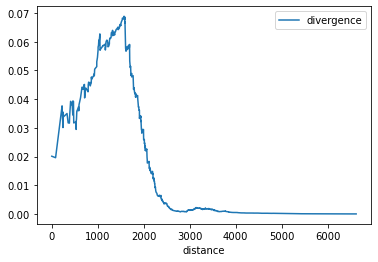

In [67]:
output.plot("distance", "divergence")

This scatter plot also shows the divergence values over the distance away from the first point.

However, this makes it much clearer to see that the points are actually quite clustered, which indicate that it is slightly arbitrary to consider the population as aggregating equally by using our method of finding te nearest neighbour.

<AxesSubplot:xlabel='distance', ylabel='divergence'>

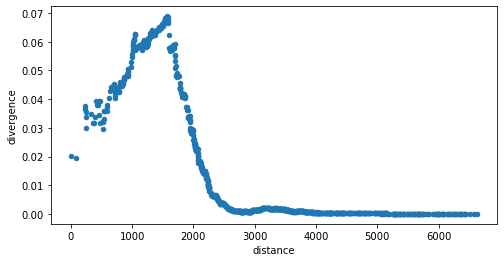

In [68]:
f,ax = plt.subplots(1, 1, figsize=(8,4))

output.plot.scatter('distance', 'divergence', ax = ax)

In order to get a better idea of the approximate divergence values at a given distance, the `interp1d` function can be used from the `scipy.interpolate` library. This is able to plot smoothed lines of different forms that are able to give approximations of levels between each point, as you can see from the output of the graph below.

In [69]:
from scipy.interpolate import interp1d

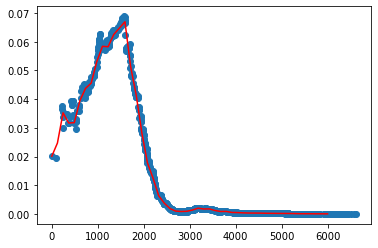

In [70]:
 # function using linear splines 
smooth = interp1d(output.distance, output.divergence, 'linear')
plt.scatter(output.distance, output.divergence)
plt.plot(np.linspace(0, 6000), smooth(np.linspace(0, 6000)), color = 'red')

In [71]:
def divergence_profile(populations, geometries):
    """
    Description of the function here.
    
    Reference to paper here.
    
    Arguments
    populations : form(s) of input
                  form(s) of input
    geometries : form(s) of input
                 form(s) of input
    selectioninput1 : form of input
        Description of what this is and what it does here.
    selectioninput2 : form of input
        Description of what this is and what it does here.
    
    Returns
    ----------
    Description of the format of return
    
    Example
    ----------
    Basic written example here, using test data if possible or creating simple dataframe to run
    """
    # Creating a distance matrix
    centroids = geometries.geometry.centroid

    centroid_coords = np.column_stack((centroids.x, centroids.y))

    dist_matrix = distance_matrix(centroid_coords, centroid_coords)
    
    # Preparing list for results
    results = []
    
    # Loop to calculate KL divergence profile
    for (i, distances) in enumerate(dist_matrix):

        ## Creating the q and r objects
        sorted_indices = np.argsort(distances)
    
        cumul_pop_by_group = np.cumsum(populations
                              [sorted_indices], axis = 0)

        obs_cumul_pop = np.sum(cumul_pop_by_group, axis = 1)[:,np.newaxis]

        Q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop

        total_pop_by_group = np.sum(populations, axis = 0, keepdims=True)

        total_pop = np.sum(populations)

        R_total_proportions = total_pop_by_group / total_pop

        ## Inputting the q and r objects into relative entropy (KL divergence) function

        kl_div_profile = scipy.special.rel_entr(Q_cumul_proportions, 
                                                R_total_proportions).sum(axis = 1)
        
        ## Creating object for population at each distance
        pop_within_dist = obs_cumul_pop.sum(axis=1)

        ## Creating an output dataframe
        output = pd.DataFrame().from_dict(dict(
            observation = i,
            distance = distances[sorted_indices],
            divergence = kl_div_profile.round(decimals = 6),
            pop_within_dist = pop_within_dist
        ))
        
        ## Append (bring together) all outputs into results list
        results.append(output)
    
        print(output)

        
# Trial run

fp_leics_eth = "../Example Data - Leicester, UK/leicester_ethnicity.gpkg"

leicester_ethnicity = gpd.read_file(fp_leics_eth)

geodata = leicester_ethnicity

groups = ['w', 'm', 'a', 'b', 'o']

leicester_ethnicity_population_matrix = geodata[groups].values.astype(float)

divergence_profile(leicester_ethnicity_population_matrix, leicester_ethnicity)

     observation     distance  divergence  pop_within_dist
0              0     0.000000    0.338912            413.0
1              0    99.848749    0.289084            674.0
2              0   196.450146    0.306364            968.0
3              0   201.022948    0.264342           1257.0
4              0   217.405943    0.274224           1487.0
..           ...          ...         ...              ...
964            0  8764.893857    0.000004         328771.0
965            0  8889.141852    0.000002         328993.0
966            0  8901.756684    0.000001         329299.0
967            0  8925.709227    0.000000         329606.0
968            0  8960.055913    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0              1     0.000000    0.164547            359.0
1              1   177.909969    0.143928            584.0
2              1   206.924416    0.108838            865.0
3              1   251.073602   

     observation     distance  divergence  pop_within_dist
0             40     0.000000    0.322430            290.0
1             40   145.660177    0.274812            595.0
2             40   231.930416    0.219641            938.0
3             40   292.222267    0.231118           1230.0
4             40   378.758911    0.221291           1508.0
..           ...          ...         ...              ...
964           40  9379.829416    0.000004         328771.0
965           40  9507.932920    0.000002         328993.0
966           40  9515.487508    0.000001         329299.0
967           40  9546.339104    0.000000         329606.0
968           40  9569.507296    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0             41     0.000000    0.303315            292.0
1             41   154.011976    0.262577            597.0
2             41   250.505844    0.292895            938.0
3             41   292.222267   

     observation     distance  divergence  pop_within_dist
0             77     0.000000    0.348255            237.0
1             77   123.501639    0.329965            538.0
2             77   153.264136    0.304739            835.0
3             77   171.851042    0.297396           1144.0
4             77   220.587715    0.319744           1380.0
..           ...          ...         ...              ...
964           77  7898.418580    0.000000         328606.0
965           77  8018.654893    0.000000         328947.0
966           77  8047.062384    0.000000         329283.0
967           77  8273.822218    0.000000         329591.0
968           77  8586.417765    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0             78     0.000000    0.416506            266.0
1             78   207.057150    0.406675            555.0
2             78   210.613712    0.407012            870.0
3             78   233.278163   

     observation     distance  divergence  pop_within_dist
0            124     0.000000    0.594653            450.0
1            124   165.978454    0.604730            867.0
2            124   199.960472    0.535089           1330.0
3            124   207.454612    0.507892           1817.0
4            124   214.283013    0.527702           2294.0
..           ...          ...         ...              ...
964          124  8326.282323    0.000004         328771.0
965          124  8410.394542    0.000002         328993.0
966          124  8427.691097    0.000001         329300.0
967          124  8470.755440    0.000000         329606.0
968          124  8565.813538    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            125     0.000000    0.565123            399.0
1            125   107.622192    0.486649            644.0
2            125   130.580273    0.514798            825.0
3            125   178.076453   

     observation     distance  divergence  pop_within_dist
0            167     0.000000    0.351065            307.0
1            167   204.939303    0.410098            761.0
2            167   280.529811    0.396509           1103.0
3            167   323.269938    0.389298           1497.0
4            167   507.401529    0.381859           1912.0
..           ...          ...         ...              ...
964          167  9407.938179    0.000001         328570.0
965          167  9427.863636    0.000001         328887.0
966          167  9445.436674    0.000000         329262.0
967          167  9538.521745    0.000000         329598.0
968          167  9564.886115    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            168     0.000000    0.464702            454.0
1            168   173.665190    0.421360            796.0
2            168   204.939303    0.396509           1103.0
3            168   307.026148   

     observation     distance  divergence  pop_within_dist
0            206     0.000000    0.050015            353.0
1            206   149.224997    0.126678            479.0
2            206   151.212419    0.074551            774.0
3            206   191.004267    0.127277           1275.0
4            206   195.803418    0.074821           1853.0
..           ...          ...         ...              ...
964          206  6092.018028    0.000001         328711.0
965          206  6176.038239    0.000000         328942.0
966          206  6236.935877    0.000000         329250.0
967          206  6344.097818    0.000000         329591.0
968          206  6569.910089    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            207     0.000000    0.127936            220.0
1            207   162.803211    0.033588            633.0
2            207   164.349226    0.021735            874.0
3            207   166.054111   

     observation     distance  divergence  pop_within_dist
0            246     0.000000    0.318355            450.0
1            246   112.421702    0.264337            941.0
2            246   132.768890    0.250843           1413.0
3            246   193.901473    0.244800           1670.0
4            246   202.309268    0.244695           2073.0
..           ...          ...         ...              ...
964          246  7266.301579    0.000004         328771.0
965          246  7307.851665    0.000002         328993.0
966          246  7314.084455    0.000001         329300.0
967          246  7393.957518    0.000000         329606.0
968          246  7508.151856    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            247     0.000000    0.263624            472.0
1            247   121.959772    0.392470            893.0
2            247   132.768890    0.317026           1343.0
3            247   172.592827   

     observation     distance  divergence  pop_within_dist
0            285     0.000000    0.571663            555.0
1            285    84.915778    0.596182            845.0
2            285   191.428186    0.610861           1163.0
3            285   251.699631    0.610054           1555.0
4            285   258.979264    0.592791           2012.0
..           ...          ...         ...              ...
964          285  6813.136354    0.000004         328575.0
965          285  6920.837983    0.000002         328881.0
966          285  6939.150670    0.000001         329240.0
967          285  7050.222736    0.000001         329473.0
968          285  7280.320958    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            286     0.000000    0.123508            332.0
1            286   182.287902    0.118152            680.0
2            286   238.409058    0.111559            999.0
3            286   250.795971   

     observation     distance  divergence  pop_within_dist
0            327     0.000000    0.131712            320.0
1            327   190.987864    0.069444            512.0
2            327   222.494469    0.158866            927.0
3            327   373.152967    0.149654           1256.0
4            327   403.395892    0.196961           1583.0
..           ...          ...         ...              ...
964          327  7933.757090    0.000001         328653.0
965          327  8117.521865    0.000001         328884.0
966          327  8125.723870    0.000001         329132.0
967          327  8185.133723    0.000001         329473.0
968          327  8276.192291    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            328     0.000000    0.046065            357.0
1            328   185.454006    0.065147            768.0
2            328   341.868724    0.073412           1131.0
3            328   342.553566   

     observation      distance  divergence  pop_within_dist
0            373      0.000000    0.536710            289.0
1            373    125.846718    0.444452            538.0
2            373    184.683421    0.390297            880.0
3            373    221.037766    0.411261           1183.0
4            373    304.777993    0.375438           1551.0
..           ...           ...         ...              ...
964          373   9849.013244    0.000000         328691.0
965          373   9878.013249    0.000000         328947.0
966          373   9895.238544    0.000000         329255.0
967          373  10019.788370    0.000000         329591.0
968          373  10189.844274    0.000000         329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_dist
0            374      0.000000    0.518184            186.0
1            374    188.154984    0.508668            416.0
2            374    219.192899    0.497619            666.0
3            374

     observation     distance  divergence  pop_within_dist
0            422     0.000000    0.307391            338.0
1            422   194.274215    0.318778            651.0
2            422   202.978178    0.324710            932.0
3            422   260.761755    0.272604           1299.0
4            422   270.161046    0.276440           1615.0
..           ...          ...         ...              ...
964          422  8475.667512    0.000001         328526.0
965          422  8625.585593    0.000000         328942.0
966          422  8785.937924    0.000000         329283.0
967          422  8999.423121    0.000000         329591.0
968          422  9316.337538    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            423     0.000000    0.290908            315.0
1            423   229.083781    0.250471            654.0
2            423   242.069449    0.091021           1005.0
3            423   250.688618   

     observation     distance  divergence  pop_within_dist
0            471     0.000000    0.081888            337.0
1            471   156.689592    0.011884            610.0
2            471   241.410418    0.025569           1007.0
3            471   325.042435    0.011753           1394.0
4            471   327.478087    0.019551           1795.0
..           ...          ...         ...              ...
964          471  8181.975952    0.000003         328701.0
965          471  8198.921580    0.000002         328934.0
966          471  8299.211464    0.000001         329240.0
967          471  8372.744547    0.000000         329606.0
968          471  8434.486400    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            472     0.000000    0.066823            397.0
1            472   241.410418    0.063287            734.0
2            472   252.721950    0.067981           1157.0
3            472   313.565814   

     observation     distance  divergence  pop_within_dist
0            512     0.000000    0.028111            281.0
1            512   214.998203    0.013442            623.0
2            512   242.154588    0.029562            911.0
3            512   305.474556    0.013777           1315.0
4            512   307.360852    0.015692           1731.0
..           ...          ...         ...              ...
964          512  9026.628104    0.000001         328526.0
965          512  9084.867413    0.000000         328942.0
966          512  9285.144166    0.000000         329283.0
967          512  9350.868576    0.000000         329591.0
968          512  9678.242485    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            513     0.000000    0.145912            355.0
1            513   211.106101    0.143113            756.0
2            513   280.651727    0.023431           1095.0
3            513   289.458470   

     observation     distance  divergence  pop_within_dist
0            552     0.000000    0.516096            225.0
1            552    98.610722    0.512788            459.0
2            552   134.520226    0.437948            673.0
3            552   172.876605    0.284192           1166.0
4            552   236.655868    0.277116           1391.0
..           ...          ...         ...              ...
964          552  7865.890003    0.000004         328771.0
965          552  7929.546553    0.000002         328993.0
966          552  7941.045101    0.000001         329300.0
967          552  8003.519040    0.000000         329606.0
968          552  8108.745029    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            553     0.000000    0.335063            214.0
1            553   121.439272    0.277778            439.0
2            553   134.520226    0.346685            664.0
3            553   155.265436   

     observation     distance  divergence  pop_within_dist
0            601     0.000000    0.429317            298.0
1            601   185.255685    0.372243            572.0
2            601   214.273020    0.380174            916.0
3            601   230.159652    0.366114           1225.0
4            601   245.537980    0.368599           1493.0
..           ...          ...         ...              ...
964          601  8301.182761    0.000003         328666.0
965          601  8306.201714    0.000002         328982.0
966          601  8321.946844    0.000001         329223.0
967          601  8393.316566    0.000000         329553.0
968          601  8441.992372    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            602     0.000000    0.328472            368.0
1            602   204.601433    0.375441            701.0
2            602   211.334657    0.401545            996.0
3            602   265.894191   

     observation     distance  divergence  pop_within_dist
0            649     0.000000    0.530763            385.0
1            649   198.546545    0.567067            785.0
2            649   277.312091    0.544808           1136.0
3            649   289.856327    0.580007           1406.0
4            649   302.932422    0.557047           1868.0
..           ...          ...         ...              ...
964          649  6908.954729    0.000001         328653.0
965          649  7104.226478    0.000001         328884.0
966          649  7201.908232    0.000001         329225.0
967          649  7227.430303    0.000000         329591.0
968          649  7235.575679    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            650     0.000000    0.522820            571.0
1            650   101.694873    0.492948           1031.0
2            650   118.484015    0.524108           1569.0
3            650   145.276661   

     observation     distance  divergence  pop_within_dist
0            698     0.000000    0.654016            536.0
1            698   204.106115    0.504671            919.0
2            698   233.966091    0.544752           1403.0
3            698   244.435774    0.587089           1952.0
4            698   329.867593    0.496364           2175.0
..           ...          ...         ...              ...
964          698  6614.885797    0.000004         328771.0
965          698  6710.636076    0.000002         328993.0
966          698  6733.826369    0.000001         329300.0
967          698  6758.011624    0.000000         329606.0
968          698  6844.334731    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            699     0.000000    0.649746            484.0
1            699   138.617407    0.485688            867.0
2            699   139.376123    0.496309           1381.0
3            699   178.855869   

     observation     distance  divergence  pop_within_dist
0            747     0.000000    0.010932            503.0
1            747    86.871762    0.021598           1007.0
2            747   127.601689    0.016113           1309.0
3            747   160.151139    0.047291           1787.0
4            747   192.403766    0.065044           2268.0
..           ...          ...         ...              ...
964          747  6535.217451    0.000001         328711.0
965          747  6623.216137    0.000000         328942.0
966          747  6665.885804    0.000000         329250.0
967          747  6789.620052    0.000000         329591.0
968          747  6999.578589    0.000000         329839.0

[969 rows x 4 columns]
     observation      distance  divergence  pop_within_dist
0            748      0.000000    0.235131            386.0
1            748    172.347414    0.266604            611.0
2            748    183.695124    0.238247            860.0
3            748    269.2456

     observation     distance  divergence  pop_within_dist
0            796     0.000000    0.184948            267.0
1            796   124.339781    0.155537            457.0
2            796   208.369383    0.101944            720.0
3            796   215.033342    0.125863            983.0
4            796   216.193083    0.106462           1243.0
..           ...          ...         ...              ...
964          796  7851.831258    0.000001         328631.0
965          796  7888.100057    0.000001         328887.0
966          796  7932.509416    0.000001         329128.0
967          796  7962.421036    0.000000         329503.0
968          796  8083.839136    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            797     0.000000    0.195449            313.0
1            797   183.771335    0.162583            514.0
2            797   314.022173    0.166242            763.0
3            797   347.191451   

     observation      distance  divergence  pop_within_dist
0            845      0.000000    0.085064            345.0
1            845    290.871793    0.027819            687.0
2            845    340.480609    0.036767           1011.0
3            845    364.269662    0.030898           1280.0
4            845    423.151304    0.024627           1696.0
..           ...           ...         ...              ...
964          845   9455.747288    0.000001         328526.0
965          845   9526.123427    0.000000         328942.0
966          845   9721.744606    0.000000         329283.0
967          845   9801.876966    0.000000         329591.0
968          845  10128.664120    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            846     0.000000    0.500105            295.0
1            846   211.334657    0.380119            663.0
2            846   212.491874    0.401545            996.0
3            846   2

     observation     distance  divergence  pop_within_dist
0            893     0.000000    0.017162            622.0
1            893   255.003733    0.020477            903.0
2            893   305.045009    0.014640           1476.0
3            893   322.405317    0.012992           1700.0
4            893   404.252497    0.017691           1912.0
..           ...          ...         ...              ...
964          893  6138.525732    0.000001         328646.0
965          893  6145.759054    0.000000         328976.0
966          893  6145.760235    0.000000         329262.0
967          893  6238.512149    0.000000         329598.0
968          893  6278.842632    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            894     0.000000    0.150575            252.0
1            894   106.135255    0.128963            441.0
2            894   134.402609    0.142264            642.0
3            894   164.322683   

     observation     distance  divergence  pop_within_dist
0            941     0.000000    0.190653            201.0
1            941    59.514677    0.144889            496.0
2            941   114.102513    0.122407            615.0
3            941   134.402609    0.124173            867.0
4            941   147.055790    0.119331           1056.0
..           ...          ...         ...              ...
964          941  6088.663091    0.000004         328771.0
965          941  6177.494605    0.000002         328993.0
966          941  6197.582184    0.000001         329300.0
967          941  6232.726478    0.000000         329606.0
968          941  6325.299938    0.000000         329839.0

[969 rows x 4 columns]
     observation     distance  divergence  pop_within_dist
0            942     0.000000    0.147926            184.0
1            942   145.314196    0.223539            413.0
2            942   163.254423    0.093150            846.0
3            942   255.449962   

**note to self: correct the calculation of `sum_pop_groups` throughout - explaining that adding the `, keepdims = True` gives you what you need. then explaining that you don't need to apply the `sorted` function to *global_statistics* to create the *r* object**

**also including `.sum(axis = 1)` at the end of the line calculating the KL divergence metric**